In [1]:
import random
import sys
import os
import json
sys.path.append('../')
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import torch
import torch.nn as nn
import torch.nn.functional as F

from glob import glob
from typing import List, Mapping, Tuple, Optional, Any
from collections import OrderedDict
from tqdm.notebook import tqdm
from torch.nn.modules.loss import _WeightedLoss
from catalyst import dl
from catalyst.dl import utils
from catalyst.dl import SupervisedRunner
from catalyst.contrib.nn.optimizers import RAdam, Lookahead, Adam
from catalyst.dl.callbacks import OptimizerCallback, EarlyStoppingCallback, SchedulerCallback, CriterionCallback, CheckpointCallback
from ranger_adabelief import RangerAdaBelief 
from adabelief_pytorch import AdaBelief

import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, KFold
from matplotlib import pyplot as plt

from basic_utils.data import slice_sequances, anton_slicer
from basic_utils.metric import map_per_set, map_per_image, mean_average_precision_at_k, average_precision_at_k
from nn_utils.swa import avarage_weights
from nn_utils.callbacks import MAP5Callback, CinemaMAP5Callback

%matplotlib inline

In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available else 'cpu'
print(f'Cur device : {DEVICE}')

def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    torch.manual_seed(seed_value)    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
seed_everything(1234)

Cur device : cuda


In [3]:
BS = 2048
MIN_LEN = 10
SEQ_LEN = 30
SHORTEN = 45
Y_SIZE = 5
EXP_NAME = 'timeval_2stage_2layerlstm_zhenafilter'

## Load data

In [4]:
def filter_bad_watches(input, t_thresh=10.0):
    ts = input['ts'].tolist()
    if len(ts) > 1:
        shifted_ts = [(ts[i+1] - ts[i]).seconds / 60 for i in range(len(ts)-1)] + [1_000]
    else:
        shifted_ts = [1_000]
    movie_list = input['movie_id'].tolist()
    movie_list = [el for el, time in zip(movie_list,shifted_ts) if time > t_thresh]
    return movie_list

In [5]:
movies_ts = pd.read_csv('/ssd_data/cinema_hack/movies_dataset_10 months.csv')
movies_ts['ts'] = pd.to_datetime(movies_ts['ts'])
movies_ts = movies_ts.sort_values('ts').reset_index(drop=True)

In [6]:
sample_submission = pd.read_csv('/ssd_data/cinema_hack/submission.csv')

sample_submission['movie_id'] = sample_submission[' movie_id']
sample_submission = sample_submission.drop(columns=' movie_id')

In [7]:
with open("../add_data/ActorEmbed.json", "r") as read_file:
    actor_emb = json.load(read_file)
    actor_emb = {int(k):torch.Tensor(v) for k,v in actor_emb.items()}
    
with open("../add_data/DirectorEmbed.json", "r") as read_file:
    director_emb = json.load(read_file)
    director_emb = {int(k):torch.Tensor(v) for k,v in director_emb.items()}
    
with open("../add_data/GenreEmbed.json", "r") as read_file:
    genre_emb = json.load(read_file)
    genre_emb = {int(k):torch.Tensor(v) for k,v in genre_emb.items()}
    
with open("../add_data/ratingembed.json", "r") as read_file:
    rate_emb = json.load(read_file)
    rate_emb = {int(k):torch.Tensor(v) for k,v in rate_emb.items()}

In [8]:
missed_movies = set(movies_ts['movie_id']) - set(list(map(int, actor_emb.keys())))
for el in missed_movies:
    actor_emb[el] = torch.zeros_like(actor_emb[1])
    director_emb[el] = torch.zeros_like(director_emb[1])
    genre_emb[el] = torch.zeros_like(genre_emb[1])
    rate_emb[el] = torch.zeros_like(rate_emb[1])

In [9]:
info_df = pd.read_csv('/ssd_data/cinema_hack/movies_database.csv')
available_ids = info_df.loc[info_df.available_now == 'yes', 'id']
movies_ts = movies_ts[movies_ts.movie_id.isin(available_ids)].reset_index(drop=True)

## Prepare data

In [10]:
le_film_id = preprocessing.LabelEncoder()

# Increase train index for zero padding
movies_ts['movie_id'] = le_film_id.fit_transform(movies_ts['movie_id']) + 1

sequences = movies_ts.groupby('user_id')['movie_id'].apply(list)
#sequences = movies_ts.groupby('user_id').apply(filter_bad_watches)

sequences2use = sequences[sequences.apply(len) >= MIN_LEN]

le_classes = le_film_id.classes_

In [11]:
GENRE_EMB = torch.zeros((le_film_id.classes_.shape[0]+1, genre_emb[0].shape[0]))
DIRECTOR_EMB = torch.zeros((le_film_id.classes_.shape[0]+1, director_emb[0].shape[0]))
ACTOR_EMB = torch.zeros((le_film_id.classes_.shape[0]+1, actor_emb[0].shape[0]))
RATE_EMB = torch.zeros((le_film_id.classes_.shape[0]+1, rate_emb[0].shape[0]))

In [12]:
for i in range(le_classes.shape[0]):
    GENRE_EMB[i+1] = genre_emb[le_classes[i]]
    DIRECTOR_EMB[i+1] = director_emb[le_classes[i]]
    ACTOR_EMB[i+1] = actor_emb[le_classes[i]]
    RATE_EMB[i+1] = rate_emb[le_classes[i]]

In [13]:
X_TRAIN, y_TRAIN = [], []
X_VAL, y_VAL = [], []
X_LATEST_TRAIN, y_LATEST_TRAIN = [], []

def slice_sequence(seq, num_slices):
    for i in range(1, num_slices):
        X_TRAIN.append(seq[-(i+SEQ_LEN+4): -(i+4)])
        if i == 1:
            y_TRAIN.append(seq[-(i+4):])
        else:
            y_TRAIN.append(seq[-(i+4):-(i-1)])
            
def slice_latest_sequence(seq, num_slices):
    for i in range(1, num_slices):
        X_LATEST_TRAIN.append(seq[-(i+SEQ_LEN+4): -(i+4)])
        if i == 1:
            y_LATEST_TRAIN.append(seq[-(i+4):])
        else:
            y_LATEST_TRAIN.append(seq[-(i+4):-(i-1)])

for seq in sequences2use:
    temp_val_y = seq[-Y_SIZE:]
    temp_val_x = seq[-(SEQ_LEN+Y_SIZE):-Y_SIZE]
    seq = seq[:-Y_SIZE]
    
    X_VAL.append(temp_val_x)
    y_VAL.append(temp_val_y)
    
    num_slices = len(seq) - (SEQ_LEN + Y_SIZE -1)
    if num_slices < 0:
        slice_sequence(seq, 2)
    else:
        slice_sequence(seq, num_slices+1)
        
    seq = seq[-SHORTEN:]
    
    num_slices = len(seq) - (SEQ_LEN + Y_SIZE -1)
    if num_slices < 0:
        slice_latest_sequence(seq, 2)
    else:
        slice_latest_sequence(seq, num_slices+1)

In [14]:
print("Val")
print(len(X_VAL), len(y_VAL))
print()
lens = [len(x) for x in X_VAL]
print(max(lens), min(lens), np.mean(lens), np.median(lens))

Val
1996 1996

30 5 27.351703406813627 30.0


In [15]:
print("Train")
print(len(X_TRAIN), len(y_TRAIN))
print()
lens = [len(x) for x in X_TRAIN]
print(max(lens), min(lens), np.mean(lens), np.median(lens))

Train
107619 107619

30 0 29.928284039063733 30.0


In [16]:
print("Lastest Train")
print(len(X_LATEST_TRAIN), len(y_LATEST_TRAIN))
print()
lens = [len(x) for x in X_LATEST_TRAIN]
print(max(lens), min(lens), np.mean(lens), np.median(lens))

Lastest Train
15774 15774

30 0 29.510713832889564 30.0


In [17]:
for i in range(len(X_TRAIN)):
    X_TRAIN[i] = [0]*(SEQ_LEN - len(X_TRAIN[i])) + X_TRAIN[i]
    
for i in range(len(X_VAL)):
    X_VAL[i] = [0]*(SEQ_LEN - len(X_VAL[i])) + X_VAL[i]
    
for i in range(len(X_LATEST_TRAIN)):
    X_LATEST_TRAIN[i] = [0]*(SEQ_LEN - len(X_LATEST_TRAIN[i])) + X_LATEST_TRAIN[i]

In [18]:
X_TRAIN = np.array(X_TRAIN)
# Decrease target index 
y_TRAIN = np.array(y_TRAIN) - 1

X_VAL = np.array(X_VAL)
# Decrease target index 
y_VAL = np.array(y_VAL) - 1

X_LATEST_TRAIN = np.array(X_LATEST_TRAIN)
# Decrease target index 
y_LATEST_TRAIN = np.array(y_LATEST_TRAIN) - 1

In [19]:
sequences_test = sequences.apply(lambda x: x[-SEQ_LEN:])
sequences_test = sequences_test.apply(lambda x: [0 for i in range(SEQ_LEN - len(x))] + x)

test_users_in_sequences = sorted(set(sequences_test.index) & set(sample_submission.user_id))

X_test = np.array(sequences_test[test_users_in_sequences].tolist())

In [20]:
sequence_test_pretrain = sequences.apply(lambda x: x[-(SEQ_LEN+1):])
sequence_test_pretrain = sequence_test_pretrain.apply(lambda x: [0 for i in range((SEQ_LEN+1) - len(x))] + x)
X_test_pretrain = np.array(sequence_test_pretrain[test_users_in_sequences].tolist())

In [21]:
X_test_pretrain, y_test_pretrain = X_test_pretrain[:,:-1], X_test_pretrain[:,-1] 
y_test_pretrain = y_test_pretrain - 1

In [22]:
X_test_pretrain.shape, y_test_pretrain.shape

((1694, 30), (1694,))

## Train

In [23]:
class CinemaCE(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, input, target):
        return self.loss(input, target[:,0])
    
class CinemaCEModified(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, input, target):
        return (
             self.loss(input, target[:,0]) + 
            (self.loss(input, target[:,1])*(1/2)) +
            (self.loss(input, target[:,2])*(1/3)) +
            (self.loss(input, target[:,3])*(1/4)) +
            (self.loss(input, target[:,4])*(1/5))  
        )

In [24]:
'''
class BaselineModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embeddding = nn.Embedding(4843+1, 64, padding_idx=0)
        self.rate_layer = nn.Embedding(RATE_EMB.shape[0], RATE_EMB.shape[1], _weight=RATE_EMB)
        self.rate_layer.weight.requires_grad = False
        self.genre_layer = nn.Embedding(GENRE_EMB.shape[0], GENRE_EMB.shape[1], _weight=GENRE_EMB)
        self.genre_layer.weight.requires_grad = False
        
        self.emb_dropout = nn.Dropout(0.01)

        self.cnns = nn.Sequential(
            nn.Conv1d(64 + RATE_EMB.shape[1] + GENRE_EMB.shape[1], 256, kernel_size=31),
            nn.BatchNorm1d(256),
            nn.Dropout(0.1),
            nn.LeakyReLU(),
            
            nn.Conv1d(256, 128, kernel_size=13),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.LeakyReLU(),
            
            nn.Conv1d(128, 128, kernel_size=7),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.LeakyReLU(),
        )
        
        self.fc = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(128, 4843)
        )
       
    def forward(self, x):
        x = torch.cat([
            self.embeddding(x), self.rate_layer(x), self.genre_layer(x)
        ], dim=-1)
        x = x.permute(0,2,1)
        x = self.cnns(x)
        out = self.fc(x.mean(-1))
        return out

'''
class BaselineModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embeddding = nn.Embedding(4843+1, 64, padding_idx=0)
        self.rate_layer = nn.Embedding(RATE_EMB.shape[0], RATE_EMB.shape[1], _weight=RATE_EMB)
        self.rate_layer.weight.requires_grad = False
#         self.director_layer = nn.Embedding(DIRECTOR_EMB.shape[0], DIRECTOR_EMB.shape[1], _weight=DIRECTOR_EMB)
#         self.director_layer.weight.requires_grad = False
        self.genre_layer = nn.Embedding(GENRE_EMB.shape[0], GENRE_EMB.shape[1], _weight=GENRE_EMB)
        self.genre_layer.weight.requires_grad = False
        
        self.emb_dropout = nn.Dropout(0.01)
        self.gru = nn.GRU(
            input_size=64 + RATE_EMB.shape[1] + GENRE_EMB.shape[1],
            hidden_size=128,
            num_layers=1,
            batch_first=True,
            bidirectional=False
        )
        self.inter_drop = nn.Dropout(0.1)
        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=256,
            num_layers=1,
            batch_first=True,
            bidirectional=False
        )
        self.fc = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(128 + 256, 4843)
        )
       
    def forward(self, x):
        x = torch.cat([
            self.embeddding(x), self.rate_layer(x), self.genre_layer(x)
        ], dim=-1)
        #x = self.embeddding(x)
        x = self.emb_dropout(x)
        x, gru_hidden = self.gru(x)
        x = self.inter_drop(x)
        _, (lstm_hidden, _) = self.lstm(x)
        hidden = torch.cat((gru_hidden[-1], lstm_hidden[-1]), dim=-1)
        out = self.fc(hidden)
        return out

In [25]:
def train_function(
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_val: torch.Tensor,
    y_val: torch.Tensor,
    exp_name: str = EXP_NAME,
    resume_path: Optional[str] = None,
    n_epochs: int = 999
):
    print(f"Train shapes: {X_train.shape, y_train.shape}")
    print(f"Test shapes: {X_val.shape, y_val.shape}")
    dataset_train = torch.utils.data.TensorDataset(
        X_train,
        y_train
    )
    dataloader_train = torch.utils.data.DataLoader(dataset_train, BS, shuffle=True, drop_last=True)

    dataset_val = torch.utils.data.TensorDataset(
        X_val,
        y_val
    )
    dataloader_val = torch.utils.data.DataLoader(dataset_val, BS)

    loaders = {'train':dataloader_train, 'valid': dataloader_val}
   
    model = BaselineModel().to(DEVICE)
    print(model)

    if resume_path is None:
        lr = 1e-3
        patience = 2
        stop_patience = 10
    else:
        lr = 1e-4
        patience = 1
        stop_patience = 3
        model.load_state_dict(torch.load(resume_path, map_location='cpu')['model_state_dict'])
        
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=patience, mode='min')

    criterion =  CinemaCE()#nn.CrossEntropyLoss()

    callbacks =[
                CinemaMAP5Callback(),
                OptimizerCallback(metric_key="loss", accumulation_steps=1),
                EarlyStoppingCallback(patience=stop_patience, metric='loss', minimize=True),
                SchedulerCallback(mode='epoch', reduced_metric="loss"),
                #CheckpointCallback(save_n_best=3)
            ]

    runner = SupervisedRunner()

    # Train 
    runner.train(
            model=model,
            optimizer=optimizer,
            criterion=criterion,
            scheduler=scheduler,
            loaders=loaders,
            logdir=exp_name,
            num_epochs=n_epochs,
            verbose=True,
            main_metric="loss",
            minimize_metric=True,
            callbacks=callbacks,
        ) 
    
def inference_function(
    X_array: torch.Tensor,
    exp_name: str,
    return_logits: bool = False,
    use_last: bool = False
):
    dataset = torch.utils.data.TensorDataset(
        X_array,
        torch.zeros_like(X_array)
    )
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BS)
    
    runner = SupervisedRunner()
    if use_last:
        chckp_path = f'{exp_name}/checkpoints/last.pth'
    else:
        chckp_path = f'{exp_name}/checkpoints/best.pth'
    prediction = runner.predict_loader(
        loader=dataloader, 
        model=BaselineModel().to(DEVICE), 
        resume=chckp_path
    )
    prediction = torch.cat([b['logits'].detach().cpu() for b in prediction])
    if return_logits:
        prediction = prediction.numpy()
    else:
        prediction = torch.sort(-prediction, 1).indices[:,:5].numpy()
    
    return prediction

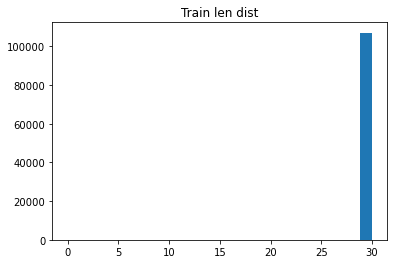

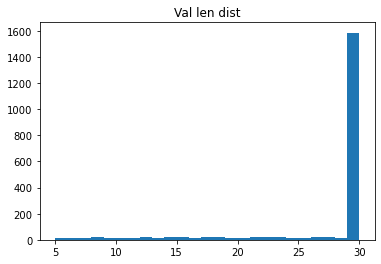

Train shapes: (torch.Size([107619, 30]), torch.Size([107619, 5]))
Test shapes: (torch.Size([1996, 30]), torch.Size([1996, 5]))
BaselineModel(
  (embeddding): Embedding(4844, 64, padding_idx=0)
  (rate_layer): Embedding(1619, 11)
  (genre_layer): Embedding(1619, 8)
  (emb_dropout): Dropout(p=0.01, inplace=False)
  (gru): GRU(83, 128, batch_first=True)
  (inter_drop): Dropout(p=0.1, inplace=False)
  (lstm): LSTM(128, 256, batch_first=True)
  (fc): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=384, out_features=4843, bias=True)
  )
)
1/999 * Epoch (train): 100% 52/52 [00:30<00:00,  1.71it/s, loss=5.372]
1/999 * Epoch (valid): 100% 1/1 [00:00<00:00,  1.86it/s, loss=6.279]
[2020-11-17 00:02:05,770] 
1/999 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/999 * Epoch 1 (train): CMAP5=0.0373 | loss=6.3008
1/999 * Epoch 1 (valid): CMAP5=0.0242 | loss=6.2795
2/999 * Epoch (train): 100% 52/52 [00:30<00:00,  1.73it/s, loss=4.896]
2/999 * Epoch (valid): 100% 1/1 [00

In [26]:
train_x_lens = [(el != 0).sum() for el in X_TRAIN]
val_x_lens = [(el != 0).sum() for el in X_VAL]

plt.title('Train len dist')
plt.hist(train_x_lens, bins=25)
plt.show()

plt.title('Val len dist')
plt.hist(val_x_lens, bins=25)
plt.show()


train_function(
    torch.LongTensor(X_TRAIN),
    torch.LongTensor(y_TRAIN),
    torch.LongTensor(X_VAL),
    torch.LongTensor(y_VAL),
    f'../logdirs/{EXP_NAME}/train'
)


In [27]:
train_function(
    torch.LongTensor(X_LATEST_TRAIN),
    torch.LongTensor(y_LATEST_TRAIN),
    torch.LongTensor(X_VAL),
    torch.LongTensor(y_VAL),
    f'../logdirs/{EXP_NAME}/short_train',
    resume_path=f'../logdirs/{EXP_NAME}/train/checkpoints/best_full.pth',
    n_epochs=30
)

Train shapes: (torch.Size([15774, 30]), torch.Size([15774, 5]))
Test shapes: (torch.Size([1996, 30]), torch.Size([1996, 5]))
BaselineModel(
  (embeddding): Embedding(4844, 64, padding_idx=0)
  (rate_layer): Embedding(1619, 11)
  (genre_layer): Embedding(1619, 8)
  (emb_dropout): Dropout(p=0.01, inplace=False)
  (gru): GRU(83, 128, batch_first=True)
  (inter_drop): Dropout(p=0.1, inplace=False)
  (lstm): LSTM(128, 256, batch_first=True)
  (fc): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=384, out_features=4843, bias=True)
  )
)
1/30 * Epoch (train): 100% 7/7 [00:04<00:00,  1.73it/s, loss=4.802]
1/30 * Epoch (valid): 100% 1/1 [00:00<00:00,  1.86it/s, loss=5.713]
[2020-11-17 00:11:30,182] 
1/30 * Epoch 1 (_base): lr=0.0001 | momentum=0.9000
1/30 * Epoch 1 (train): CMAP5=0.0589 | loss=4.7927
1/30 * Epoch 1 (valid): CMAP5=0.0393 | loss=5.7134
2/30 * Epoch (train): 100% 7/7 [00:04<00:00,  1.73it/s, loss=4.768]
2/30 * Epoch (valid): 100% 1/1 [00:00<00:00,  1

### FineTune on Test

In [ ]:
finetune_dataset = torch.utils.data.TensorDataset(
    torch.LongTensor(X_test_pretrain),
    torch.LongTensor(y_test_pretrain)
)
finetune_dataloader = torch.utils.data.DataLoader(finetune_dataset, 128, shuffle=True, drop_last=True)

loaders = {'train':finetune_dataloader}

model = BaselineModel().to(DEVICE)
print(model)

model.load_state_dict(torch.load(
    f'../logdirs/{EXP_NAME}/short_train/checkpoints/best_full.pth', 
    map_location='cpu'
)['model_state_dict'])

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

criterion = nn.CrossEntropyLoss()

callbacks =[
            OptimizerCallback(metric_key="loss", accumulation_steps=1),
        ]

runner = SupervisedRunner()

# Train 
runner.train(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        loaders=loaders,
        logdir=f'../logdirs/{EXP_NAME}/test',
        num_epochs=15,
        verbose=True,
        main_metric="loss",
        minimize_metric=True,
        callbacks=callbacks,
    ) 

In [28]:
val_pred = inference_function(
    torch.LongTensor(X_VAL),
    f'../logdirs/{EXP_NAME}/short_train',
    return_logits=True
)

test_pred = inference_function(
    torch.LongTensor(X_test),
    f'../logdirs/{EXP_NAME}/short_train',
    return_logits=True,
    use_last=True
)

## Compute score and create submit

In [29]:
import numpy as np

def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(list(a),list(p),k) for a,p in zip(actual, predicted)])

In [30]:
from itertools import chain
from scipy.special import softmax

In [31]:
val_recomend = np.argsort(-val_pred)[:,:5]
val_recomend

array([[ 339,  670, 1020,  640,  525],
       [1327, 1225, 1416, 1031,  639],
       [ 640,  461, 1416,  908, 1234],
       ...,
       [ 640, 1020,  908,  855,  339],
       [ 420,  503,  461,  337, 1416],
       [1556, 1126,  983, 1283,  155]])

In [32]:
val_score = mean_average_precision_at_k(
    list(y_VAL),
    list(val_recomend)
)
print(f"val score: {val_score}")

val score: 0.040018370073480414


In [33]:
val_loss = torch.load(f'../logdirs/{EXP_NAME}/short_train/checkpoints/best.pth', map_location='cpu')['valid_metrics']['loss']
print(f" val losse : {val_loss}")

 val losse : 5.6916399002075195


In [34]:
processed_test_preds = np.argsort(-test_pred)[:,:5]
processed_test_preds

array([[ 416, 1283, 1126,  234,  276],
       [ 461, 1416,  855,  503, 1321],
       [1404, 1348,  233,   74,  125],
       ...,
       [ 332, 1416,  699,  908,  743],
       [1283,   79,   44,  973, 1327],
       [1344, 1324, 1348,  916,  954]])

In [35]:
np.save(f'../test_preds/{EXP_NAME}_shorttest.npy', np.array([
    test_pred, test_users_in_sequences, val_pred, y_VAL, sequences2use.index.tolist(), le_film_id.classes_
]))

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [36]:
final_processed_test_preds = [le_film_id.inverse_transform(row) for row in processed_test_preds]
final_processed_test_preds = [' '.join(map(lambda x: str(x), row)) for row in final_processed_test_preds]

In [37]:
sample_submission.index = sample_submission.user_id
sample_submission.loc[test_users_in_sequences, 'movie_id'] = final_processed_test_preds

In [38]:
sample_submission

user_id                       movie_id
user_id                                                                  
16975709365084587137  16975709365084587137      5 16995 10632 17041 17756
10225505309438393880  10225505309438393880   18520 1755 15624 17425 18521
337894458057354820      337894458057354820  20118 15295 15285 18026 15387
16389753737490268206  16389753737490268206  17909 19279 15311 18548 18142
12377183607123393787  12377183607123393787   3584 17014 18520 17756 19853
...                                    ...                            ...
16073255054457636768  16073255054457636768   18943 16238 10630 18790 7347
18217982949448186449  18217982949448186449   18943 18790 19490 17756 7347
8493046014808115881    8493046014808115881   3008 16587 17364 18520 18528
6524731807859816855    6524731807859816855    7351 7347 18943 10630 17014
17611799088817908833  17611799088817908833   3476 12304 16238 15489 13563

[1695 rows x 2 columns]

In [39]:
sample_submission.to_csv(f'../subs/{EXP_NAME}_onemodel_2stage.csv', index=False)

In [40]:
results = pd.read_csv('../timeval_exp_results.csv')
results

name     score       loss
0                                    timeval_baseline  0.042301   6.051367
1                          timeval_baseline_ratingemb  0.043072   6.018055
2                       timeval_baseline_modifiedloss  0.036402  14.894038
3                           timeval_baseline_10seqlen  0.042426   6.104122
4          timeval_baseline_rateemb_genreemb_10seqlen  0.042642   6.012377
5           timeval_baseline_rateemb_useremb_10seqlen  0.040631   6.109758
6         timeval_2layerrnn_30seqlen_rateemb_genreemb  0.044262   5.974574
7      timeval_2layerrnn_30seqlen_rateemb_genreembSWA  0.044405   5.974574
8   timeval_2layerrnn_30seqlen_antonseq_rateemb_ge...  0.040948   6.132596
9   timeval_2layerrnn_rateemb_useremb_genremb_30se...  0.040636   6.072208
10                                     timeval_3stage  0.044805   5.934238
11                          timeval_3stage_biggerlstm  0.046342   5.891449
12                          timeval_2stage_2layerlstm  0.040459   6.063952

In [41]:
results = results.append({
    'name':EXP_NAME,
    'score':val_score,
    'loss': val_loss
}, ignore_index=True)

In [42]:
results

name     score       loss
0                                    timeval_baseline  0.042301   6.051367
1                          timeval_baseline_ratingemb  0.043072   6.018055
2                       timeval_baseline_modifiedloss  0.036402  14.894038
3                           timeval_baseline_10seqlen  0.042426   6.104122
4          timeval_baseline_rateemb_genreemb_10seqlen  0.042642   6.012377
5           timeval_baseline_rateemb_useremb_10seqlen  0.040631   6.109758
6         timeval_2layerrnn_30seqlen_rateemb_genreemb  0.044262   5.974574
7      timeval_2layerrnn_30seqlen_rateemb_genreembSWA  0.044405   5.974574
8   timeval_2layerrnn_30seqlen_antonseq_rateemb_ge...  0.040948   6.132596
9   timeval_2layerrnn_rateemb_useremb_genremb_30se...  0.040636   6.072208
10                                     timeval_3stage  0.044805   5.934238
11                          timeval_3stage_biggerlstm  0.046342   5.891449
12                          timeval_2stage_2layerlstm  0.040459   6.063952
13              timeval_2stage_2layerlstm_zhenafilter  0.040018   5.691640

In [ ]:
results.to_csv('../timeval_exp_results.csv', index=False)